In [2]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp


@tf.function
def find_peaks2d_tf(image,mask = None, ordered=True,threshold=None):
    if mask is not None:
      #  mask = np.atleast_2d(mask)
        if mask.shape != image.shape:
            print("Warning: mask not compatible with image -> ignoring.")
            mask = tf.ones(image.shape)
        else:
            # Make sure mask is binary, i.e. turn nonzero values into ones
            mask = tf.cast(tf.cast(mask,bool),float)
    else:
        mask = tf.ones(image.shape)
        
    if threshold is None:
        threshold = tf.math.reduce_min(image)
    else:
        threshold = tf.math.reduce_max((threshold,tf.math.reduce_min(image)))


    offset = tf.math.reduce_min(image)
    threshold = threshold - offset
    image = image - offset

    map0 = image[1:-1, 1:-1]

    # Extract shifted maps
    map1 = image[0:-2, 0:-2]
    map2 = image[1:-1, 0:-2]
    map3 = image[2:, 0:-2]
    map4 = image[0:-2, 1:-1]
    map5 = image[2:, 1:-1]
    map6 = image[0:-2, 2:]
    map7 = image[1:-1, 2:]
    map8 = image[2:, 2:]

    merge = ((map0 > map1) & (map0 > map2) & (map0 > map3) & (map0 > map4) &
             (map0 > map5) & (map0 > map6) & (map0 > map7) & (map0 > map8))
    
    bordered = tf.pad(merge,tf.constant(((1,1),(1,1))),constant_values=0.0)
    peaksmap = tf.cast(bordered,float)*image*mask
    XY = tf.where(peaksmap > threshold)
    heights = tf.gather_nd(image,XY) + offset

    if ordered:
        ind = tf.argsort(heights)[::-1]
        return tf.gather(XY[:,0],ind),tf.gather(XY[:,1],ind),tf.gather(heights,ind)
    return XY[:,0], XY[:,1],heights

@tf.function
def peaks_histogram_tf(image, bins=None, mask=None):
    """Compute a histogram of peaks in a 2d image.
    Parameters
    ----------
    image : tensor (2D)
        Two-dimensional input tensor
    bins : int or tensor (1D), optional
        Specification of bin edges or the number of bins to use for the
        histogram. If not provided, a default of 10 bins linearly spaced
        between the image minimum and maximum (inclusive) is used.
    mask : tensor (same shape as `image`), optional
        Tensor identifying which pixels of `image` to consider/exclude
        in finding peaks. Can either either be numeric (0 or 1) or boolean 
        (false or true)
    Returns
    -------
    counts, bins : tuple of 1D tensors
        Histogram and bin boundary values. If the returned `counts` has 
        N values, `bin_edges` will have N + 1 values.
     """
    if bins is None:
        bins = tf.linspace(tf.math.reduce_min(image), tf.math.reduce_max(image), 10)
    elif isinstance(bins, int):
        bins = tf.linspace(tf.math.reduce_min(image), tf.math.reduce_max(image), bins)
    else:
        bins = bins
    x, y, heights = find_peaks2d_tf(image, threshold=None, mask=mask)
    counts = tfp.stats.histogram(heights,bins)
    return counts,bins


In [134]:
kTNG = np.load('kappa_tng.npy').reshape([1024, 1024]).astype('float32')

In [222]:
from DifferentiableHOS.transforms import starlet2d
skTNG = starlet2d(kTNG.reshape([1,1024,1024]))[0][0,:,:,0]

In [223]:
bins = tf.linspace(-0.01, 0.06, 32)
ref_counts, ref_bins = peaks_histogram_tf(skTNG, bins=bins)
ref_bins = 0.5*(ref_bins[0:-1] + ref_bins[1:])

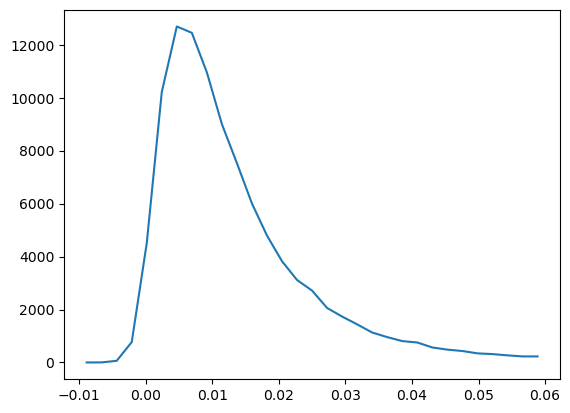

In [224]:
plot(ref_bins, ref_counts)

In [225]:
def _kernel(bw, X, x):
    """Gaussian kernel for KDE"""
    return (1.0 / np.sqrt(2 * np.pi) / bw) * tf.math.exp(
        -((X - x) ** 2) / (bw ** 2 * 2.0)
    )

In [226]:
def diffable_peaks_histogram_tf(image, bins=None, mask=None):
    """Compute a histogram of peaks in a 2d image.
    Parameters
    ----------
    image : tensor (2D)
        Two-dimensional input tensor
    bins : int or tensor (1D), optional
        Specification of bin edges or the number of bins to use for the
        histogram. If not provided, a default of 10 bins linearly spaced
        between the image minimum and maximum (inclusive) is used.
    mask : tensor (same shape as `image`), optional
        Tensor identifying which pixels of `image` to consider/exclude
        in finding peaks. Can either either be numeric (0 or 1) or boolean 
        (false or true)
    Returns
    -------
    counts, bins : tuple of 1D tensors
        Histogram and bin boundary values. If the returned `counts` has 
        N values, `bin_edges` will have N + 1 values.
     """
    x, y, heights = find_peaks2d_tf(image, threshold=None, mask=mask)
    
    w = tf.reshape(tf.ones_like(heights), [-1])
    w = w / tf.reduce_sum(w)
    k = _kernel(0.001, tf.reshape(heights,[-1,1]), bins)
    counts = tf.tensordot(k, w, axes = [[0], [0]])
    return counts,bins

In [227]:
bins = tf.linspace(-0.01, 0.06, 32)
bins = 0.5*(bins[0:-1] + bins[1:])
counts, bins = diffable_peaks_histogram_tf(skTNG, bins=bins)

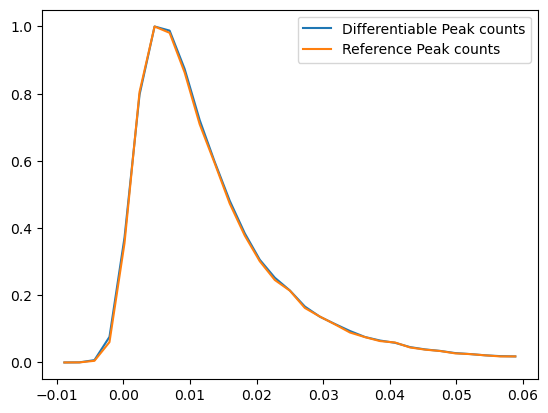

In [228]:
plot(bins, counts/counts.numpy().max(), label='Differentiable Peak counts')
plot(ref_bins, ref_counts/ref_counts.numpy().max(), label='Reference Peak counts')
legend()

In [229]:
# For testing we'll use a smaller map
bins = tf.linspace(-0.01, 0.05, 8)
ref_counts, ref_bins = peaks_histogram_tf(skTNG[:64,:64], bins=bins)
ref_bins = 0.5*(ref_bins[0:-1] + ref_bins[1:])

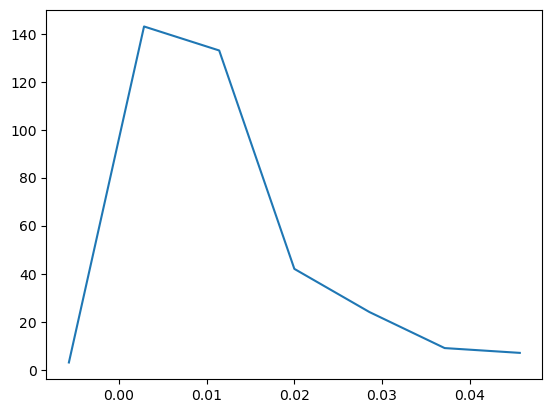

In [230]:
plot(ref_bins, ref_counts)

In [249]:
@tf.function
def compute_gradient_diff(kmap):
  """ Function that actually computes the Jacobian of a given statistics
  """
  kmap = tf.convert_to_tensor(kmap, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(kmap)
    r = starlet2d(tf.reshape(kmap, [1,64,64]))[0][0,:,:,0]
    bins = tf.linspace(-0.01, 0.06, 16)
    bins = 0.5*(bins[0:-1] + bins[1:])
    counts, _ = diffable_peaks_histogram_tf(r,bins=bins)
    counts=tf.reduce_sum(counts)
  jac = tape.gradient(counts, kmap)
  return jac 

In [250]:
dl2_tf = compute_gradient_diff(kTNG[:64,:64])

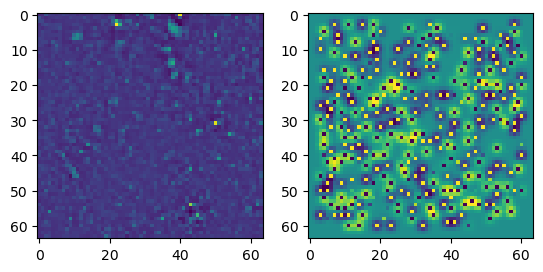

In [251]:
subplot(121)
imshow(skTNG[:64,:64])
subplot(122)
imshow(dl2_tf.numpy(),vmin=-100, vmax=100)

In [252]:
import numdifftools as nd
@tf.function
def func(kmap):
    kmap=tf.cast(kmap,dtype=tf.float32)
    kmap=tf.reshape(kmap,[64,64])
    kmap = starlet2d(tf.reshape(kmap, [1,64,64]))[0][0,:,:,0]
    bins = tf.linspace(-0.01, 0.06, 16)
    bins = 0.5*(bins[0:-1] + bins[1:])
    counts, _ = diffable_peaks_histogram_tf(kmap,bins=bins)
    counts=tf.reduce_sum(counts)
    return counts
dl1=nd.Gradient(func)
dl1_np=dl1(kTNG[:64,:64])

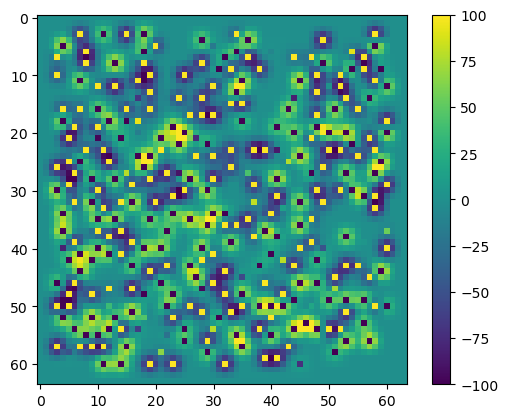

In [258]:
imshow(dl2_tf.numpy().reshape([64,64]),vmin=-100, vmax=100); colorbar()

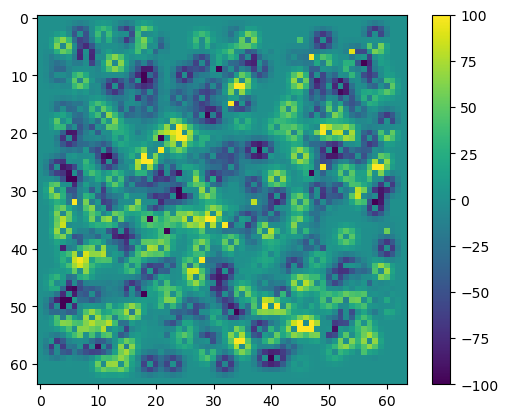

In [253]:
imshow(dl1_np.reshape([64,64]),vmin=-100, vmax=100); colorbar()

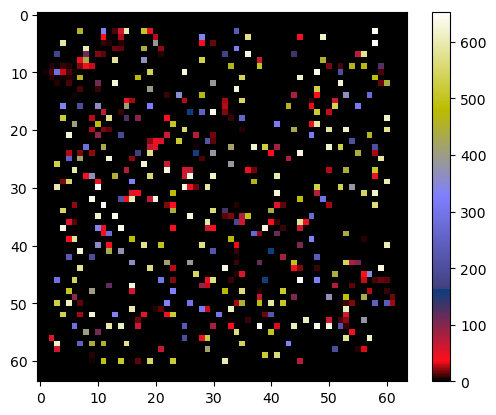

In [255]:
imshow(abs(dl1_np.reshape([64,64]) - dl2_tf.numpy()),cmap='gist_stern'); colorbar()

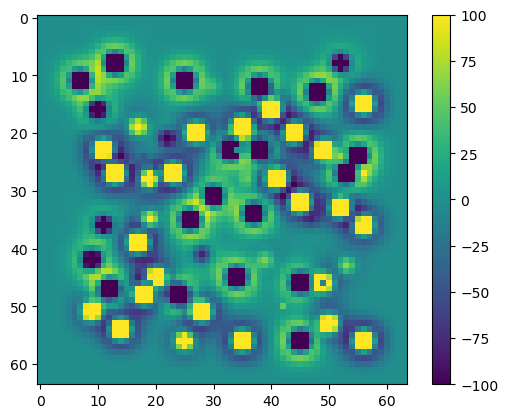

In [239]:
imshow(dl1_np.reshape([64,64]),vmin=-100, vmax=100); colorbar()

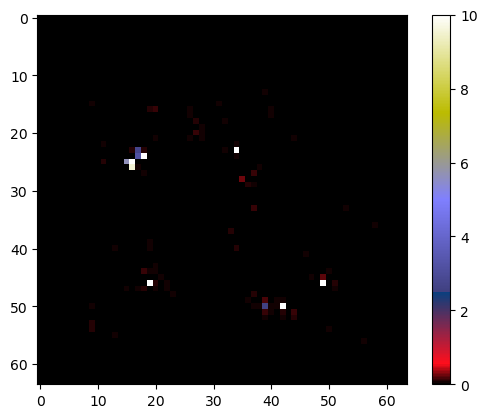

In [248]:
imshow(abs(dl1_np.reshape([64,64]) - dl2_tf.numpy()),cmap='gist_stern',vmax=10); colorbar()

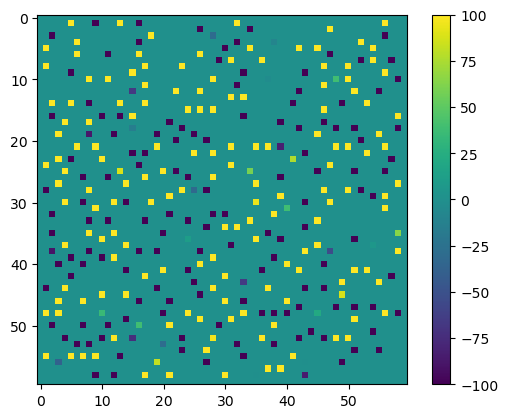

In [196]:
imshow(dl2_tf.numpy(),vmin=-100, vmax=100); colorbar()

In [187]:
import numdifftools as nd
@tf.function
def func(kmap):
    kmap=tf.cast(kmap,dtype=tf.float32)
    kmap=tf.reshape(kmap,[64,64])
    kmap = starlet2d(tf.reshape(kmap, [1,64,64]))[0][0,:,:,0]
    bins = tf.linspace(-0.01, 0.06, 16)
    counts, _ = peaks_histogram_tf(kmap, bins=bins)
    counts=tf.reduce_sum(counts)
    return counts
dl1b=nd.Gradient(func)
dl1b_np=dl1b(kTNG[:64,:64])

InvalidArgumentError:  Input arr must be non-negative!
	 [[{{node PartitionedCall/histogram/count_integers/bincount/Bincount}}]] [Op:__inference_func_470443]

Function call stack:
func


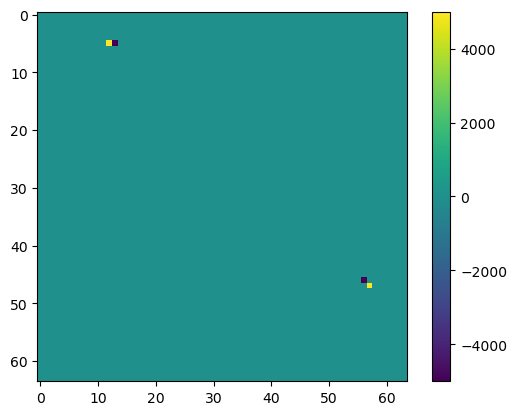

In [186]:
imshow(dl1b_np.reshape([64,64])); colorbar()